# About the Dataset

The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y). The following website provides more details of the dataset used in this notebook.

http://archive.ics.uci.edu/ml/datasets/Bank+Marketing


In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction import DictVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score , plot_roc_curve

from joblib import dump,load
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline  

In [2]:
df = pd.read_csv("data/bank_data.csv",sep=';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [5]:
# renaming columns
df.columns = df.columns.str.lower().str.replace('.', '_')

In [6]:
# matplotlib and seaborn setting
plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

sns.set(rc={'figure.figsize':(8,8)})
sns.set_theme(style="darkgrid")
# sns.set(font_scale=0.7)

### Target Distribution

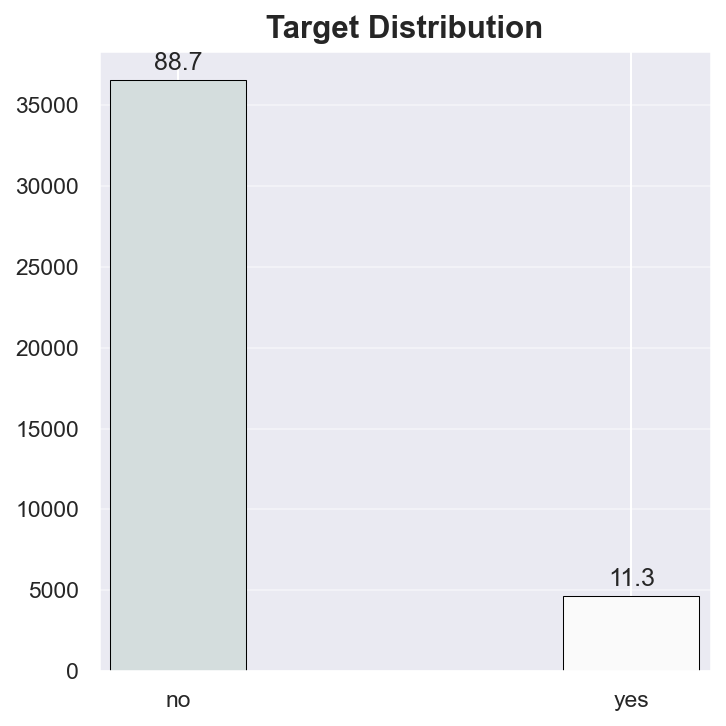

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

target_cnt = df['y'].value_counts().sort_index()

ax.bar(target_cnt.index, target_cnt, color=['#d4dddd' if i%2==0 else '#fafafa' for i in range(9)],
       width=0.30, 
       edgecolor='black', 
       linewidth=0.5)

ax.margins(0.02, 0.05)

for i in range(2):
    ax.annotate(f'{target_cnt[i]/len(df)*100:.3}', xy=(i, target_cnt[i]+1000),
                   va='center', ha='center',
               )

ax.set_title('Target Distribution', weight='bold', fontsize=15)
ax.grid(axis='y', linestyle='-', alpha=0.4)

fig.tight_layout()
plt.show()

* Clealy imbalanced data here where 'no' account for 88.7% whole 'yes' only for 11.3.

### Data Types

In [8]:
df_numerical = df.select_dtypes(exclude="object") 
df_catgorical = df.select_dtypes(include="object")

Number of Numerical features: 10
Number of Categorical features: 11


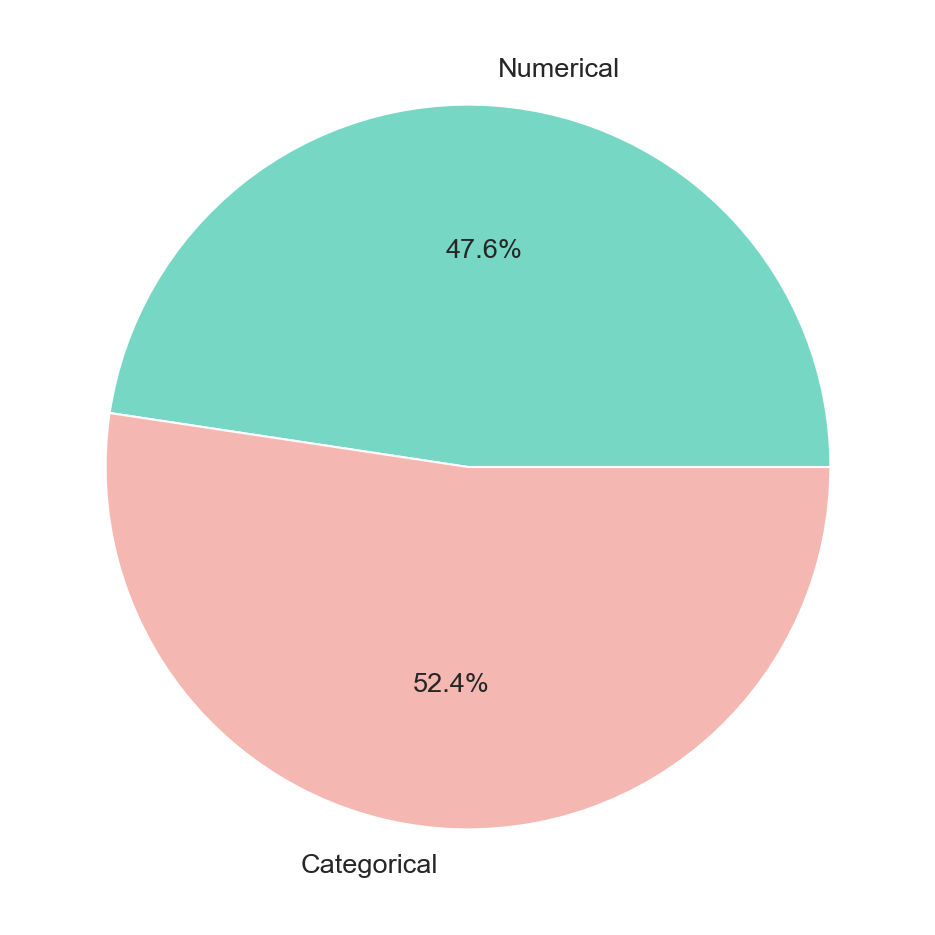

In [9]:
print(f'Number of Numerical features: {len(df_numerical.columns)}')
print(f'Number of Categorical features: {len(df_catgorical.columns)}')

plt.pie([len(df_numerical.columns), len(df_catgorical.columns)], 
        labels=['Numerical', 'Categorical'],
        colors=['#76D7C4', '#F5B7B1'],
        textprops={'fontsize': 13},
        autopct='%1.1f%%')
plt.show()

### Statistics

In [10]:
df_numerical.describe().round().T.style.bar(subset=['mean'], color='#205ff2')\
                            .background_gradient(subset=['std'], cmap='Reds')\
                            .background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
age,41188.000000,40.000000,10.000000,17.000000,32.000000,38.000000,47.000000,98.000000
duration,41188.000000,258.000000,259.000000,0.000000,102.000000,180.000000,319.000000,4918.000000
campaign,41188.000000,3.000000,3.000000,1.000000,1.000000,2.000000,3.000000,56.000000
pdays,41188.000000,962.000000,187.000000,0.000000,999.000000,999.000000,999.000000,999.000000
previous,41188.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000
emp_var_rate,41188.000000,0.000000,2.000000,-3.000000,-2.000000,1.000000,1.000000,1.000000
cons_price_idx,41188.000000,94.000000,1.000000,92.000000,93.000000,94.000000,94.000000,95.000000
cons_conf_idx,41188.000000,-41.000000,5.000000,-51.000000,-43.000000,-42.000000,-36.000000,-27.000000
euribor3m,41188.000000,4.000000,2.000000,1.000000,1.000000,5.000000,5.000000,5.000000
nr_employed,41188.000000,5167.000000,72.000000,4964.000000,5099.000000,5191.000000,5228.000000,5228.000000


* The sclae of data is diverse. And data needs to be normalised/scaled depending on the model, tree based models tends to to handle outliers nicely.
*  Mix data of both int and floating type.
* The range of data is diverse
* pdays feature needs to be looked into detail. 999 needs replacing with 0 as dataset notes suggests.
* duration will be dropped as per dataset notes because of predictive influence

### Discrete Features

As above we found data some data of integer type, let's try to dig in a bit.

In [11]:
discrete_features = []

for col in df_numerical.columns:
    if np.array_equal(df_numerical[col].values, df_numerical[col].values.astype(int)):
        discrete_features.append(col)

print(f'Total {len(discrete_features)} : ')
print(discrete_features)

Total 5 : 
['age', 'duration', 'campaign', 'pdays', 'previous']


A total of 5 features have no decimal point.
* Age
* Duration
* Campaign
* Pdays
* Previous

In [12]:
print(f'Unique values as follows:-')
for dcol in discrete_features:
    print(f'{dcol}: {df_numerical[dcol].nunique()}')

Unique values as follows:-
age: 78
duration: 1544
campaign: 42
pdays: 27
previous: 8


### Numerical Feature Distribution

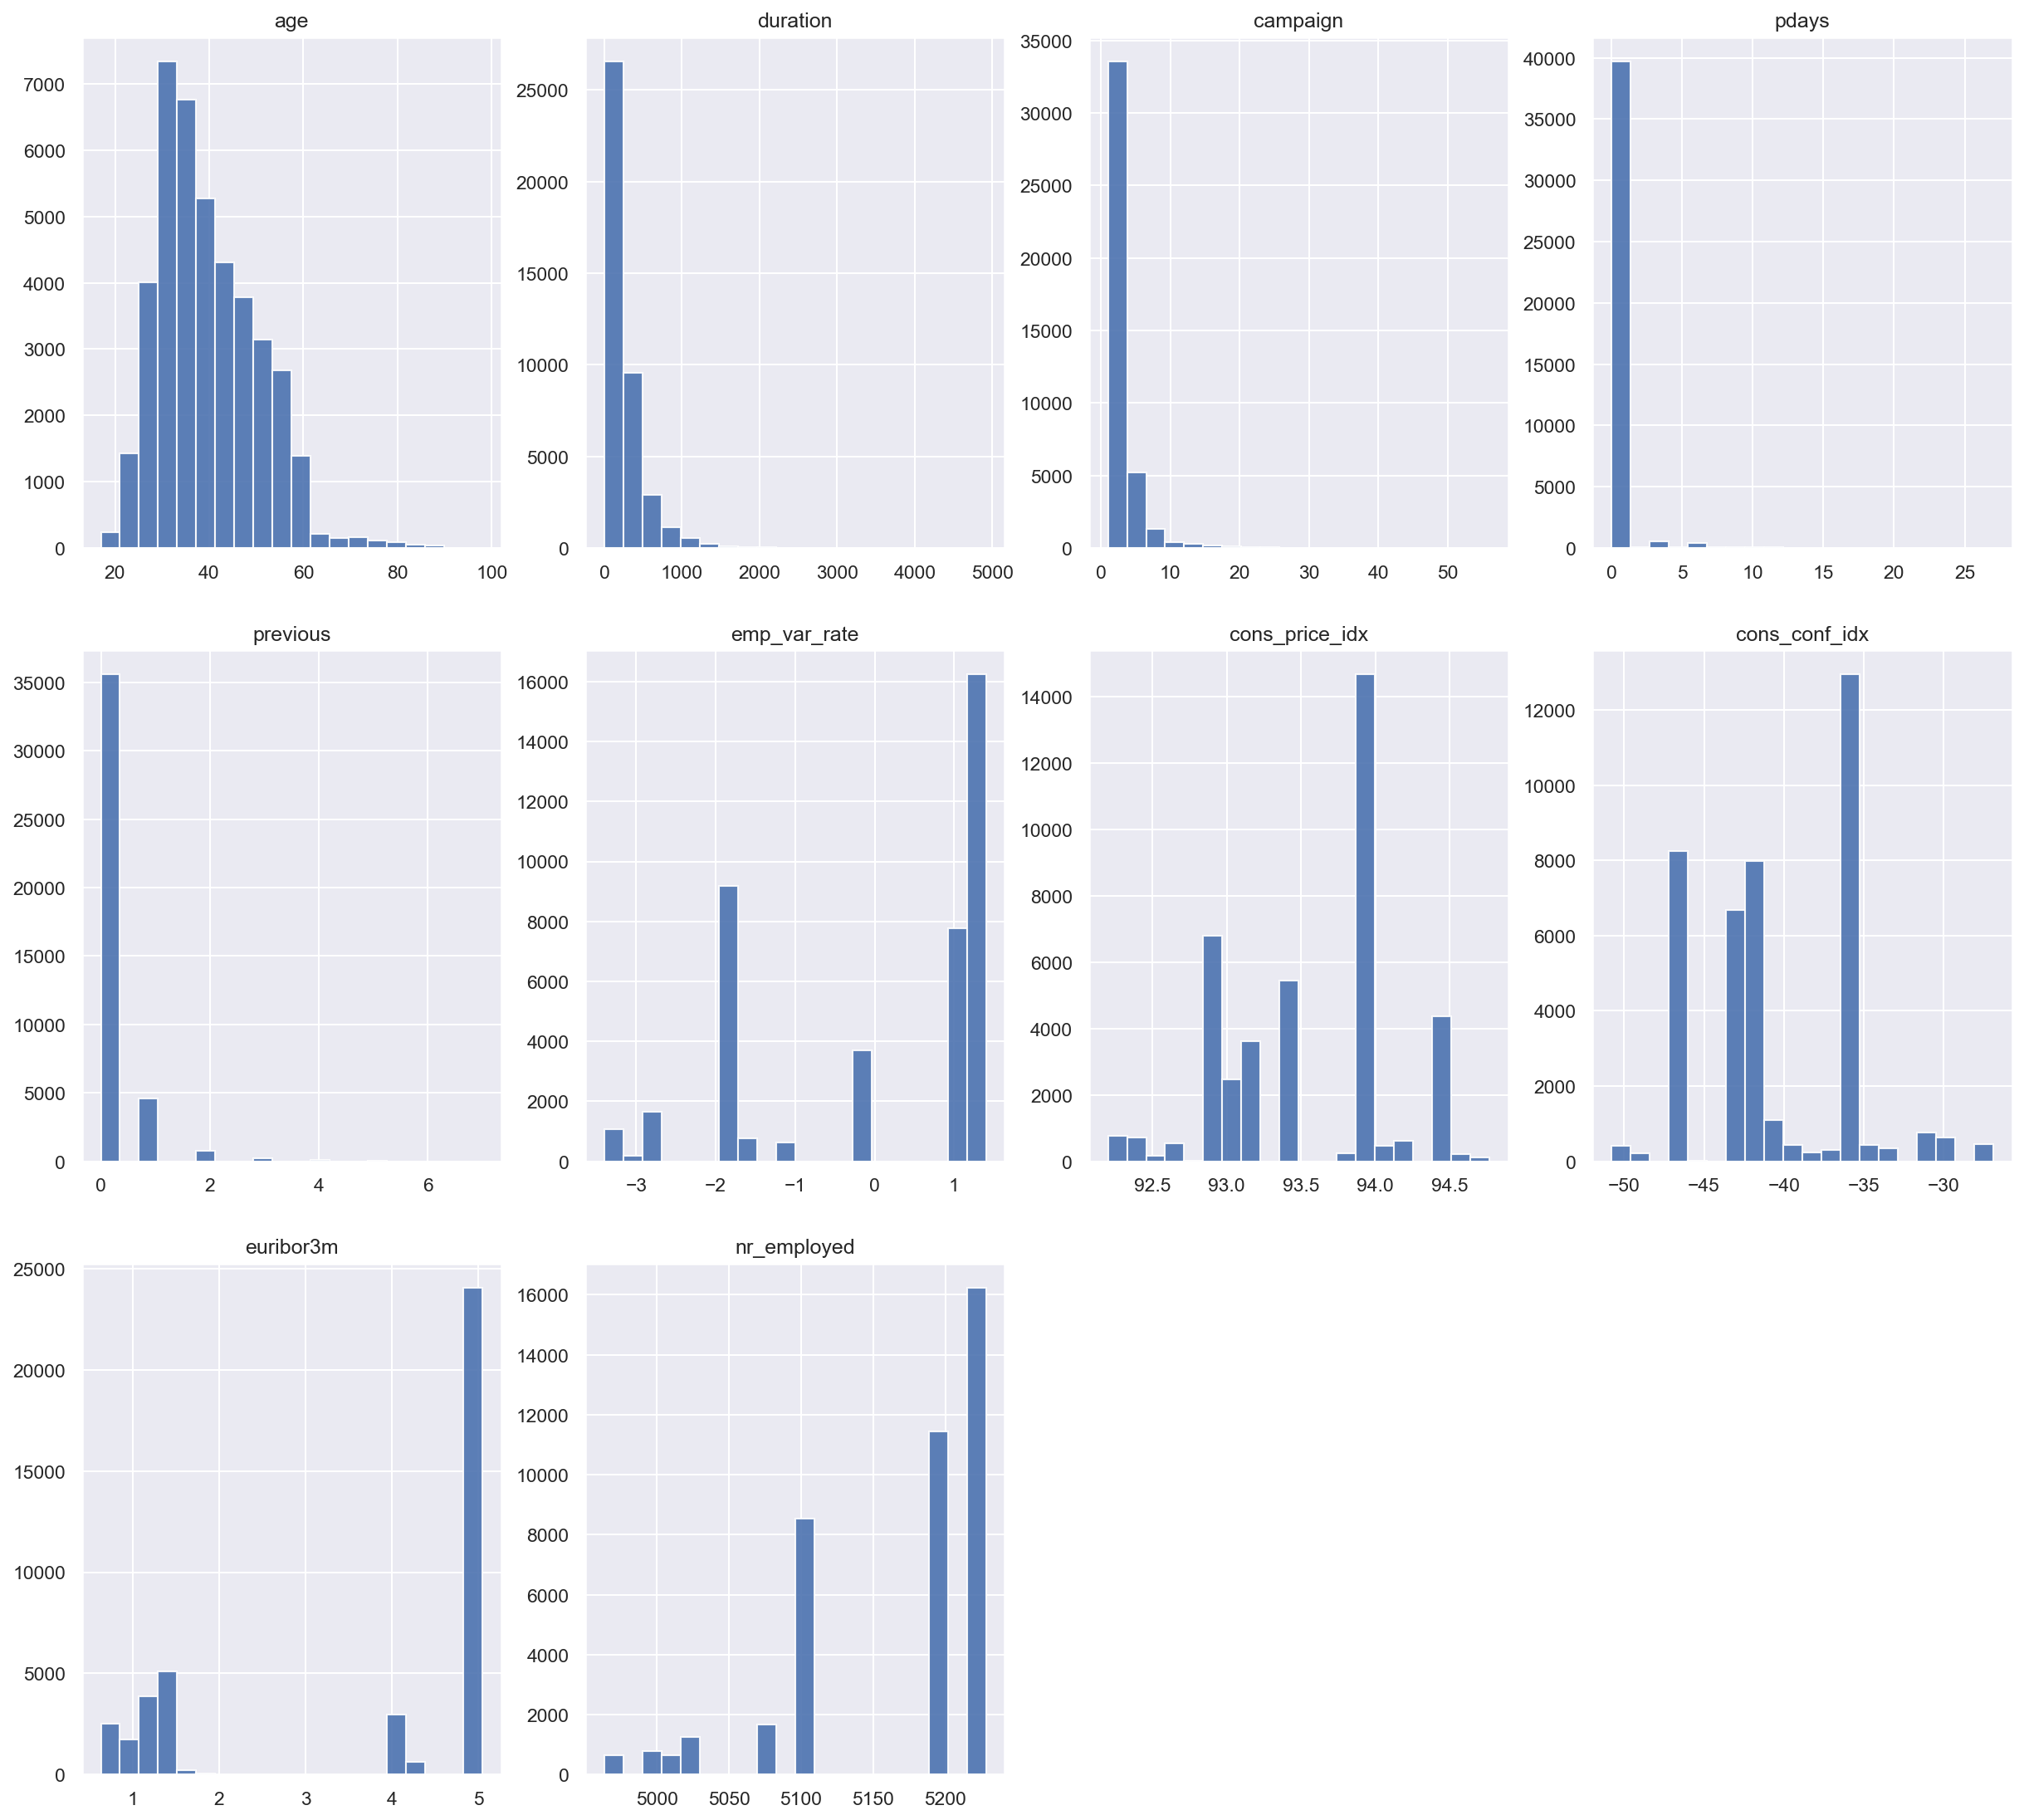

In [38]:
fig = plt.figure(figsize = (20, 25))
for idx, i in enumerate(df_numerical.columns):
    fig.add_subplot(4, 4, idx+1)
#     sns.kdeplot(data = df_numerical.iloc[:, idx],
#                fill = True)
    df_numerical.iloc[:, idx].hist(bins=20,color='b',alpha=0.9)
    plt.subplots_adjust(hspace=0.2)
    plt.title(i)
plt.show()

0     39688
3       439
6       412
4       118
9        64
2        61
7        60
12       58
10       52
5        46
13       36
11       28
1        26
15       24
14       20
8        18
16       11
17        8
18        7
22        3
19        3
21        2
25        1
26        1
27        1
20        1
Name: pdays, dtype: int64


<AxesSubplot:>

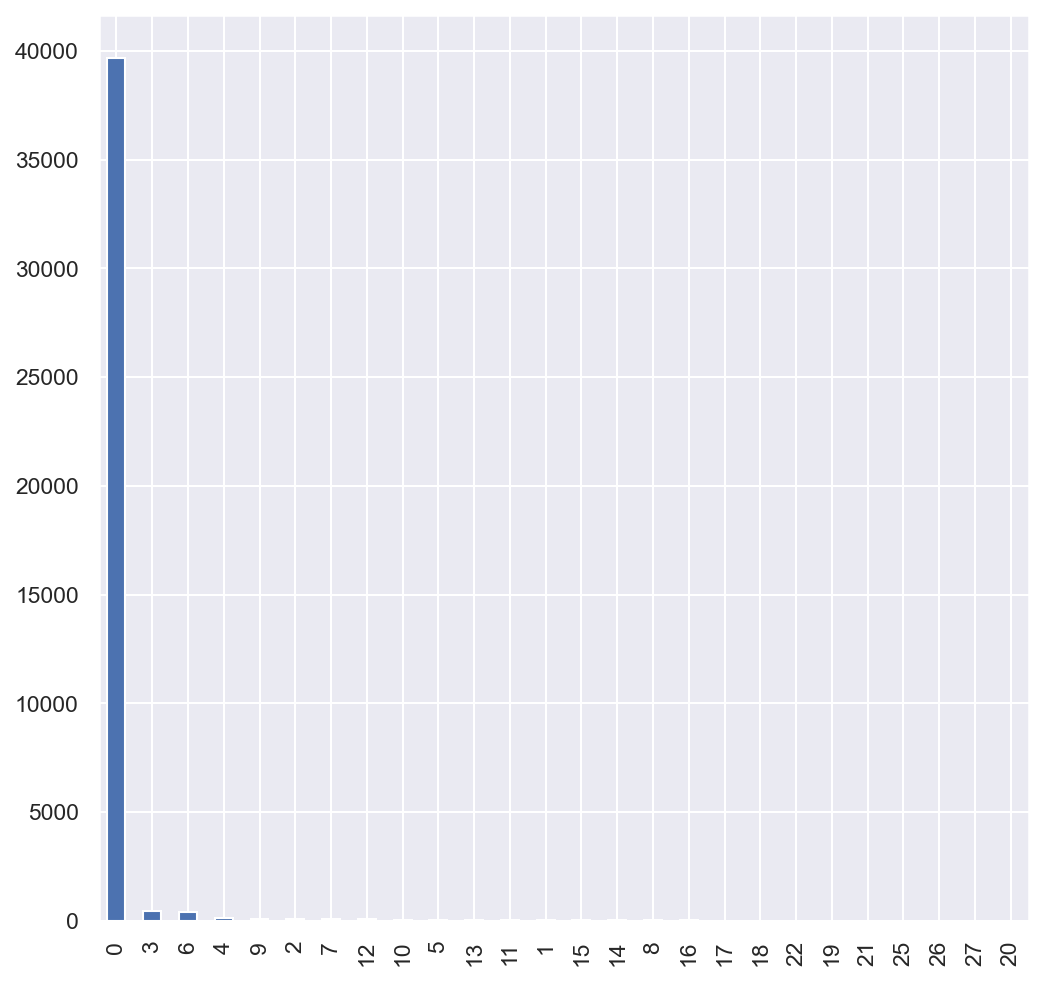

In [39]:
# pdays feature
# clearly 999 value counts for 96% of total distribution, 
# dataset notes suggested 999 means 0,replacing 999 with 0.

print(df_numerical.pdays.value_counts())
df_numerical.pdays.value_counts().plot(kind="bar")

In [40]:
df_numerical['pdays'] = df_numerical['pdays'].replace(999,0)
df_numerical.pdays.value_counts()

0     39688
3       439
6       412
4       118
9        64
2        61
7        60
12       58
10       52
5        46
13       36
11       28
1        26
15       24
14       20
8        18
16       11
17        8
18        7
22        3
19        3
21        2
25        1
26        1
27        1
20        1
Name: pdays, dtype: int64

<AxesSubplot:>

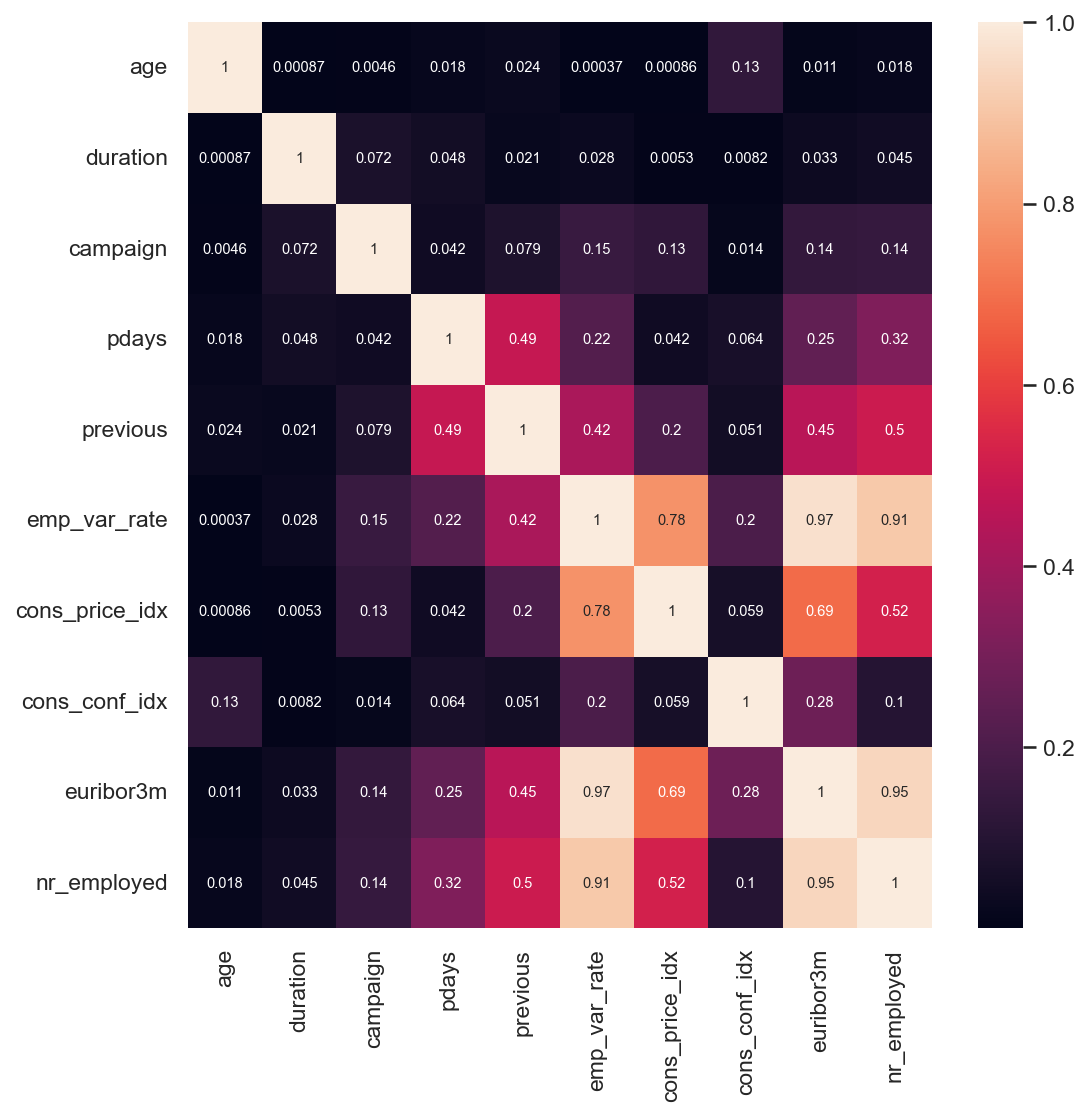

In [41]:
cor_matrix = df_numerical.corr().abs()
sns.heatmap(cor_matrix , annot= True,annot_kws={"size": 7})

<AxesSubplot:>

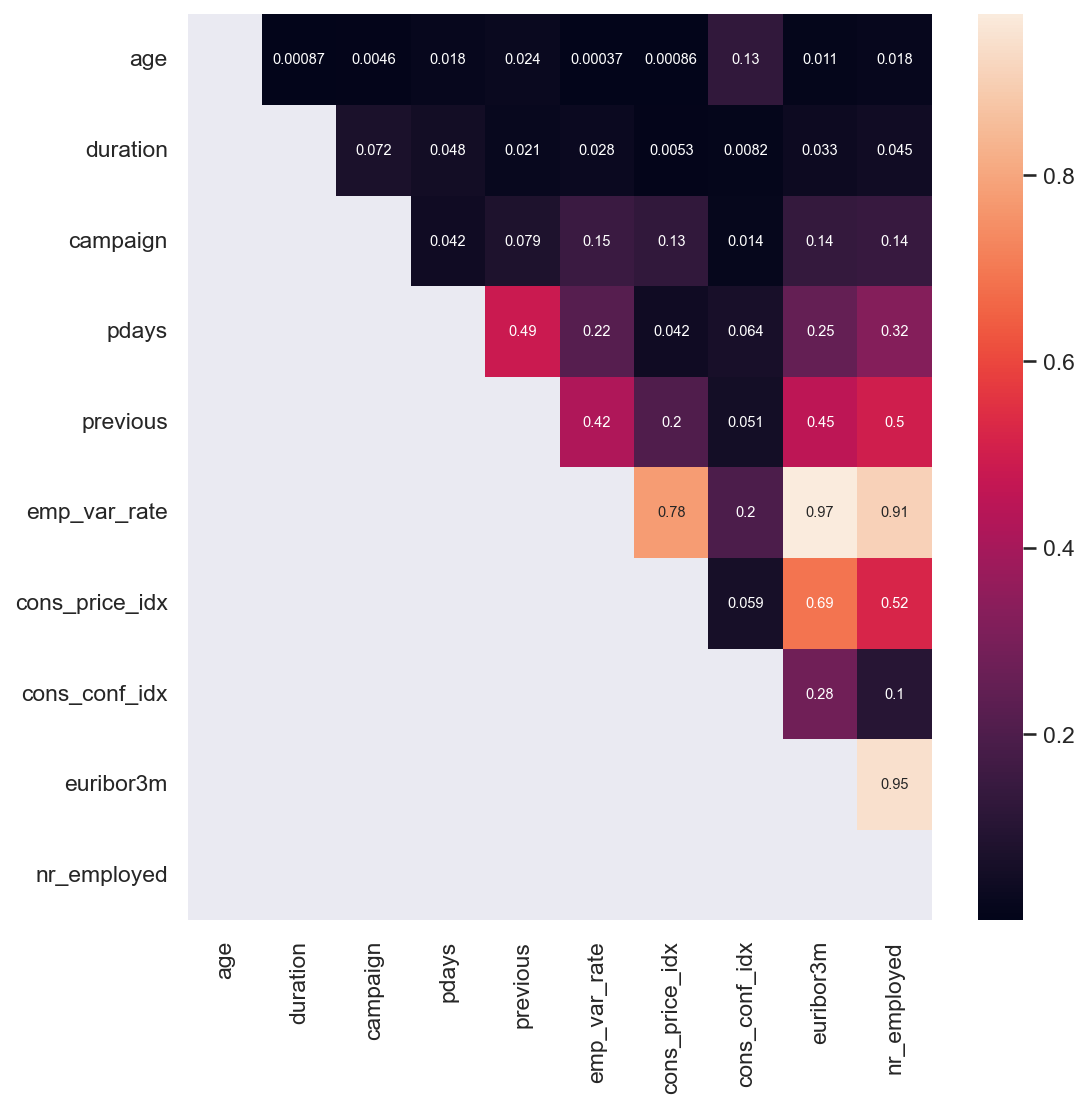

In [42]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
sns.heatmap(upper_tri , annot= True,annot_kws={"size": 7})

In [43]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.90)]
print(to_drop)

['euribor3m', 'nr_employed']


In [44]:
# Clealry nr_employed is highly correlated with euribo3m and emp_var_rate
# trying to drop euribor3m and emp_var_rate
df_numerical = df_numerical.drop(['euribor3m','nr_employed'],axis = 1)
df_numerical

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx
0,56,261,1,0,0,1.1,93.994,-36.4
1,57,149,1,0,0,1.1,93.994,-36.4
2,37,226,1,0,0,1.1,93.994,-36.4
3,40,151,1,0,0,1.1,93.994,-36.4
4,56,307,1,0,0,1.1,93.994,-36.4
...,...,...,...,...,...,...,...,...
41183,73,334,1,0,0,-1.1,94.767,-50.8
41184,46,383,1,0,0,-1.1,94.767,-50.8
41185,56,189,2,0,0,-1.1,94.767,-50.8
41186,44,442,1,0,0,-1.1,94.767,-50.8


### Categorical Feature Distribution

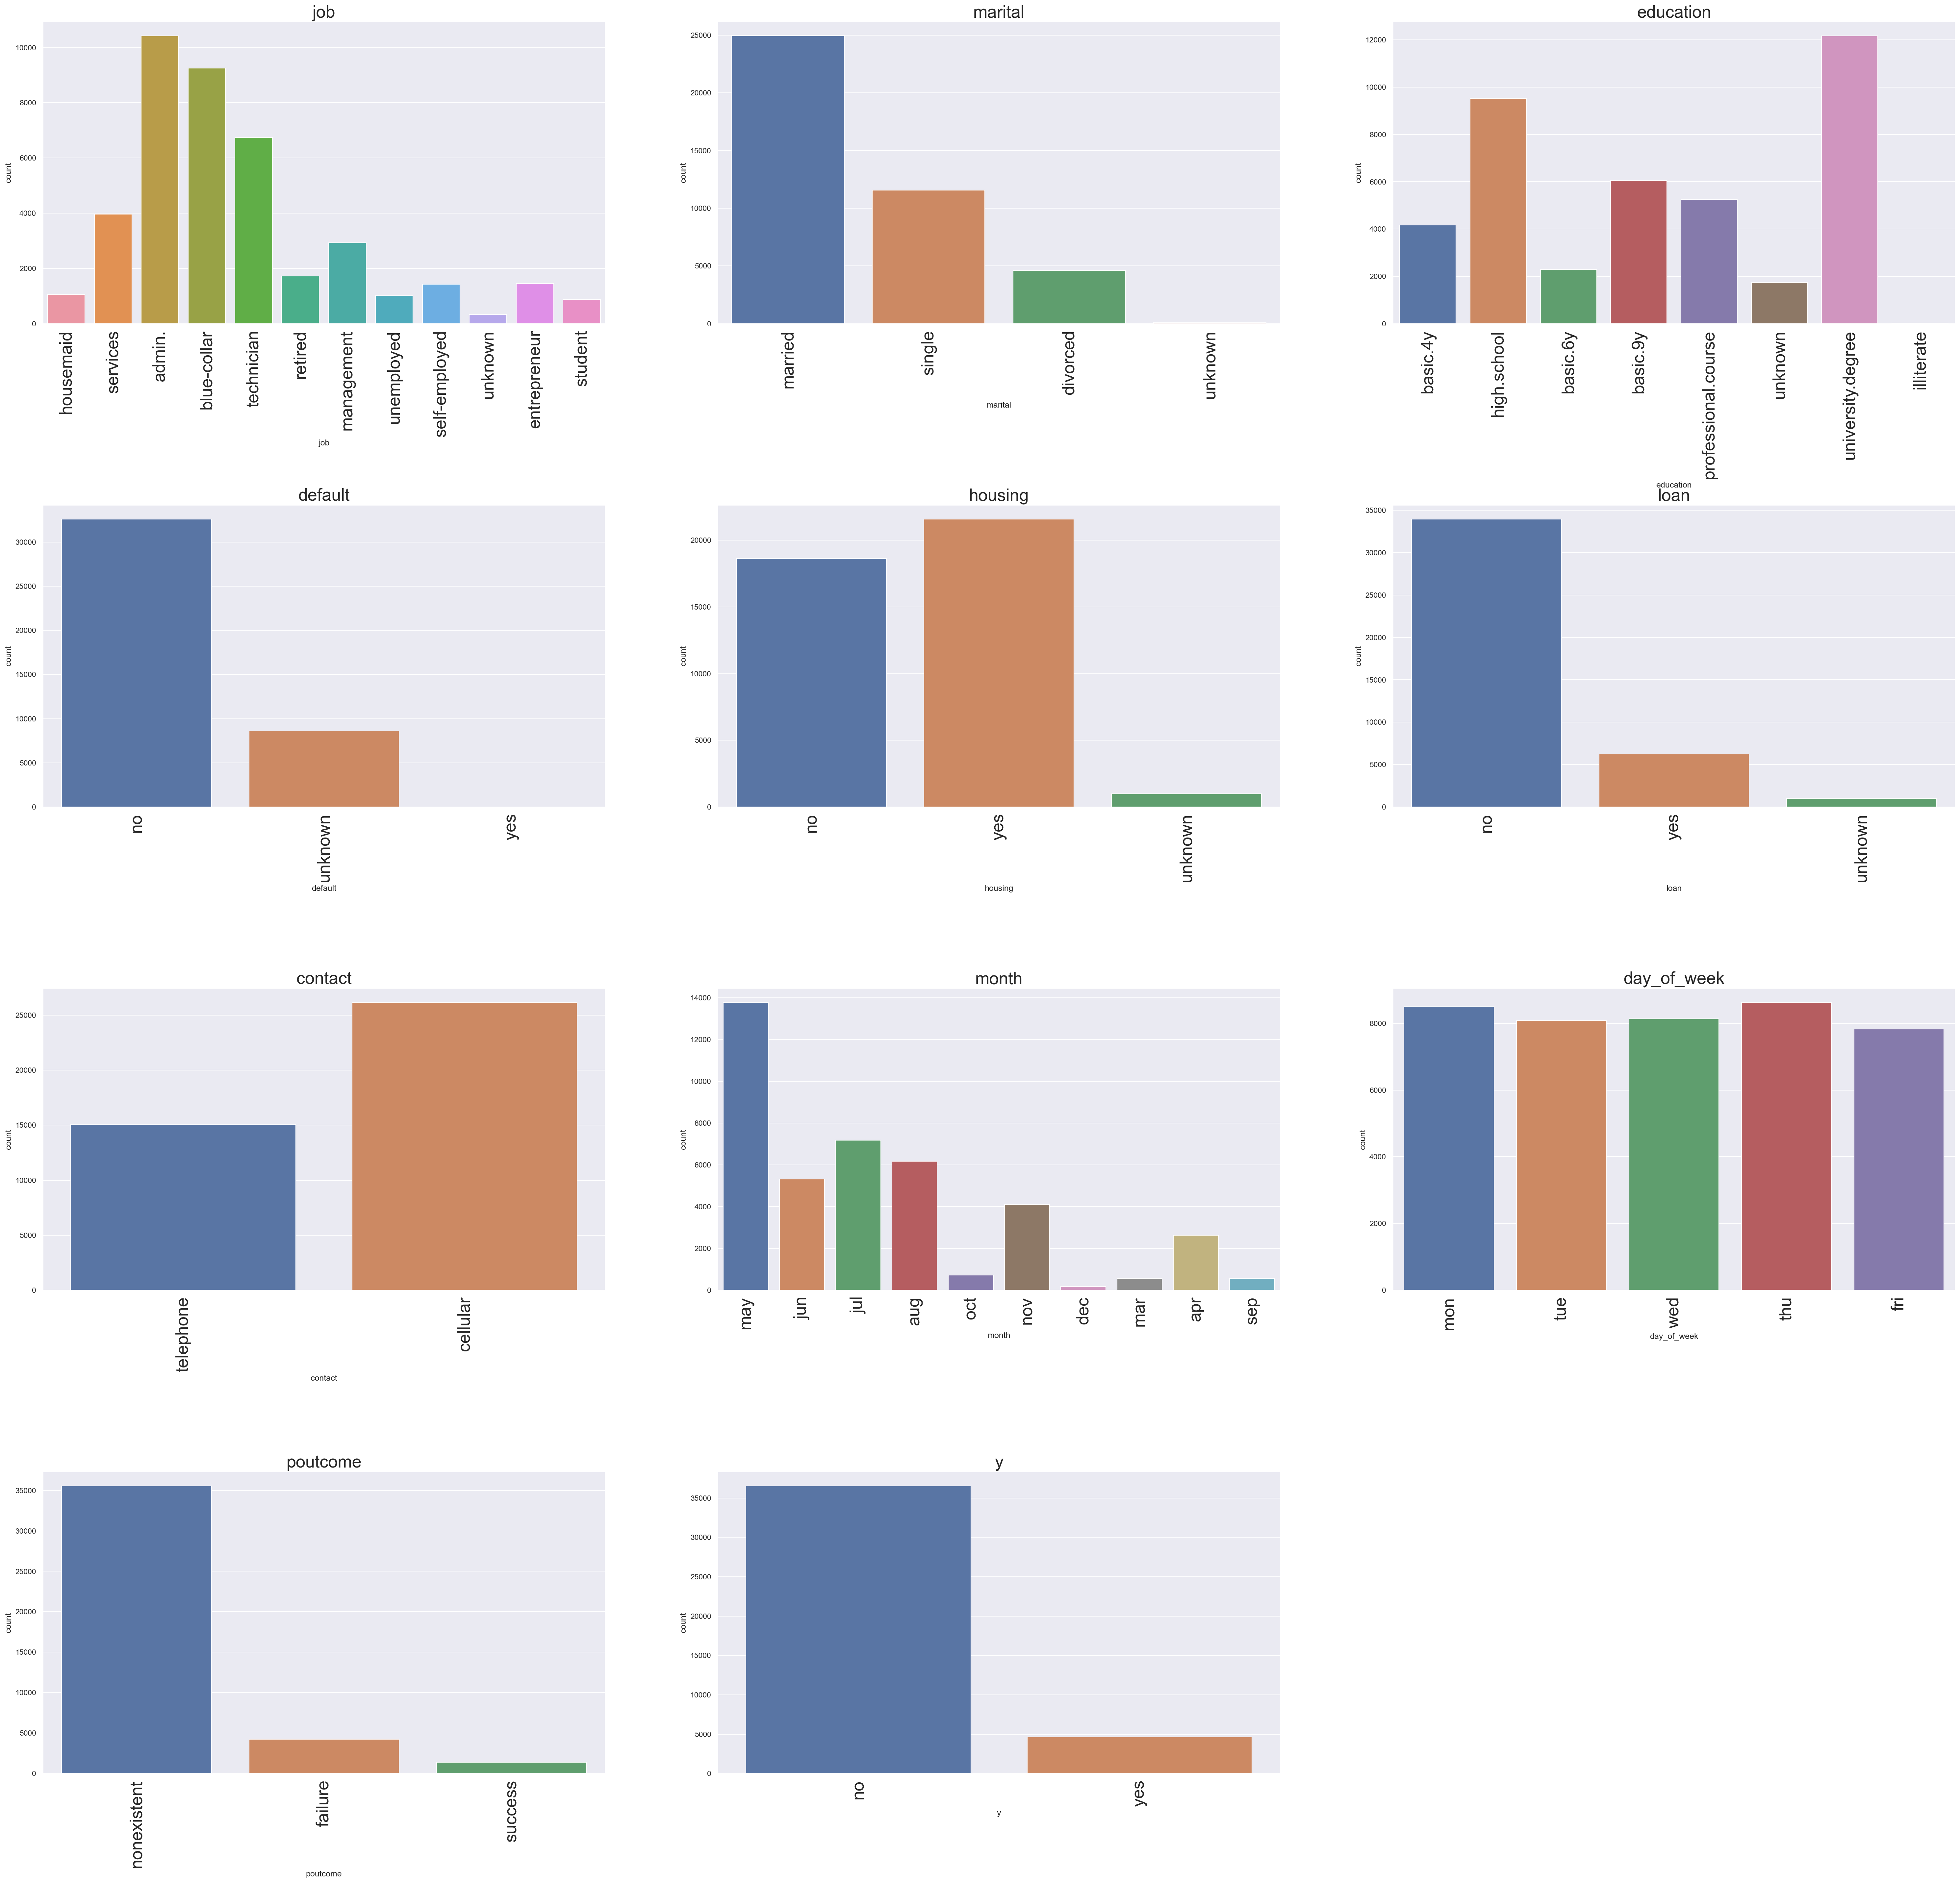

In [66]:
fig = plt.figure(figsize = (50, 60))
for idx, i in enumerate(df_catgorical.columns):
    fig.add_subplot(5, 3, idx+1)
    sns.countplot(x = df_catgorical.iloc[:, idx],)
    plt.subplots_adjust(hspace=0.6)
    locs, labels = plt.xticks(fontsize=25)
    plt.setp(labels, rotation=90)
    plt.title(i,fontsize=25)
plt.show()

In [67]:
# we need to remove duration feature as mentioned in the above notes because it's highly correlated with the target.
df_numerical = df_numerical.drop('duration', axis = 1)
df_numerical

,age,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx
0,56,1,0,0,1.1,93.994,-36.4
1,57,1,0,0,1.1,93.994,-36.4
2,37,1,0,0,1.1,93.994,-36.4
3,40,1,0,0,1.1,93.994,-36.4
4,56,1,0,0,1.1,93.994,-36.4
...,...,...,...,...,...,...,...
41183,73,1,0,0,-1.1,94.767,-50.8
41184,46,1,0,0,-1.1,94.767,-50.8
41185,56,2,0,0,-1.1,94.767,-50.8
41186,44,1,0,0,-1.1,94.767,-50.8


### Target Variable

In [68]:
target = (df.y == 'yes').astype(int)
df_catgorical.drop('y',axis = 1 , inplace = True)

In [69]:
df_numerical.corrwith(target).to_frame('correlation')

,correlation
age,0.030399
campaign,-0.066357
pdays,0.267088
previous,0.230181
emp_var_rate,-0.298334
cons_price_idx,-0.136211
cons_conf_idx,0.054878


### One Hot Encoding

In [70]:
# combine the numerical and catgorical features first before one hot encoding

df_combined = pd.concat([df_numerical,df_catgorical],axis = 1)
df_combined

,age,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,56,1,0,0,1.1,93.994,-36.4,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent
1,57,1,0,0,1.1,93.994,-36.4,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent
2,37,1,0,0,1.1,93.994,-36.4,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent
3,40,1,0,0,1.1,93.994,-36.4,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent
4,56,1,0,0,1.1,93.994,-36.4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,1,0,0,-1.1,94.767,-50.8,retired,married,professional.course,no,yes,no,cellular,nov,fri,nonexistent
41184,46,1,0,0,-1.1,94.767,-50.8,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,nonexistent
41185,56,2,0,0,-1.1,94.767,-50.8,retired,married,university.degree,no,yes,no,cellular,nov,fri,nonexistent
41186,44,1,0,0,-1.1,94.767,-50.8,technician,married,professional.course,no,no,no,cellular,nov,fri,nonexistent


In [71]:
# one encoding using DictVectorizer
df_dict = df_combined.to_dict(orient="records")

In [72]:
dv = DictVectorizer(sparse=False)
df_combined_encoded = pd.DataFrame(dv.fit_transform(df_dict))
df_combined_encoded.columns = dv.get_feature_names()

In [73]:
df_combined_encoded

,age,campaign,cons_conf_idx,cons_price_idx,contact=cellular,contact=telephone,day_of_week=fri,day_of_week=mon,day_of_week=thu,day_of_week=tue,...,month=mar,month=may,month=nov,month=oct,month=sep,pdays,poutcome=failure,poutcome=nonexistent,poutcome=success,previous
0,56.0,1.0,-36.4,93.994,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,57.0,1.0,-36.4,93.994,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,37.0,1.0,-36.4,93.994,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,40.0,1.0,-36.4,93.994,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,56.0,1.0,-36.4,93.994,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73.0,1.0,-50.8,94.767,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
41184,46.0,1.0,-50.8,94.767,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
41185,56.0,2.0,-50.8,94.767,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
41186,44.0,1.0,-50.8,94.767,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Modeling

In [74]:
X, X_test, y, y_test = train_test_split(df_combined_encoded, target, test_size=0.20,stratify = target,random_state=42)

In [75]:
clf = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
   
clf.fit(X, y)
preds = clf.predict_proba(X_test)[:,1]
roc_auc_score(y_test, preds)


0.7915155195999812

### Feature Importance

In [77]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(clf, X)
fi[:40]

,cols,imp
0,age,0.158035
55,pdays,0.124997
22,emp_var_rate,0.067967
2,cons_conf_idx,0.067071
1,campaign,0.063838
3,cons_price_idx,0.049927
58,poutcome=success,0.041088
26,job=admin.,0.018773
25,housing=yes,0.018718
23,housing=no,0.018687


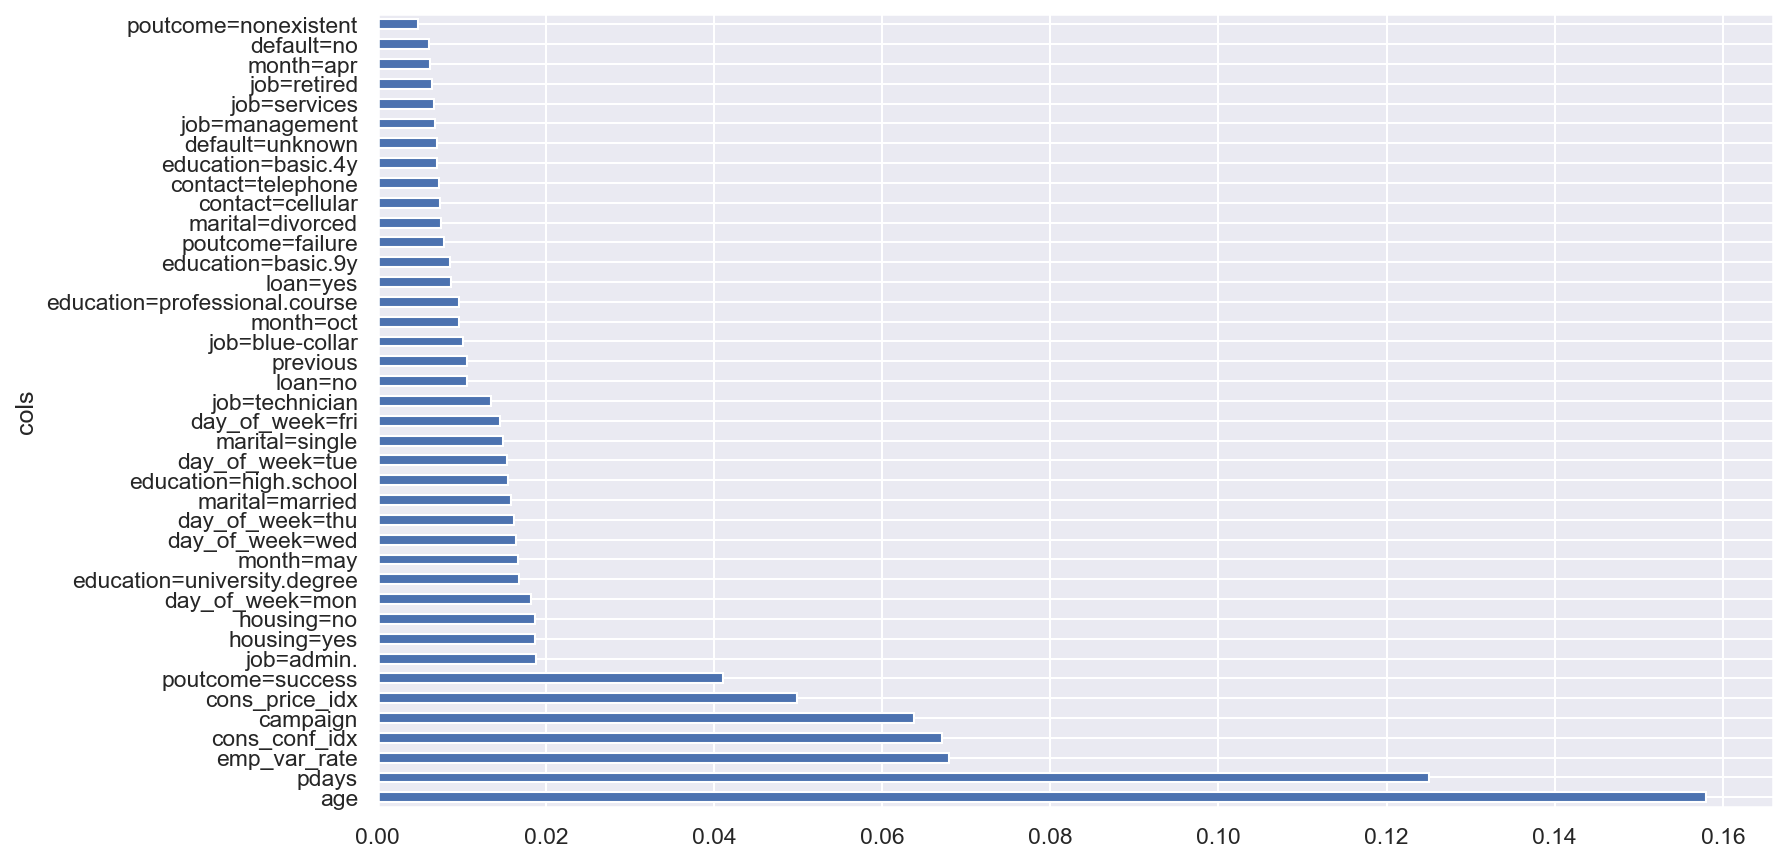

In [85]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:40]);

In [86]:
to_keep = fi[fi.imp>0.0050].cols;
len(to_keep)

39

In [87]:
clf = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
   
clf.fit(X[to_keep], y)
predicitions = clf.predict_proba(X_test[to_keep])[:,1]
roc_auc_score(y_test,predicitions)

0.7851097044671919

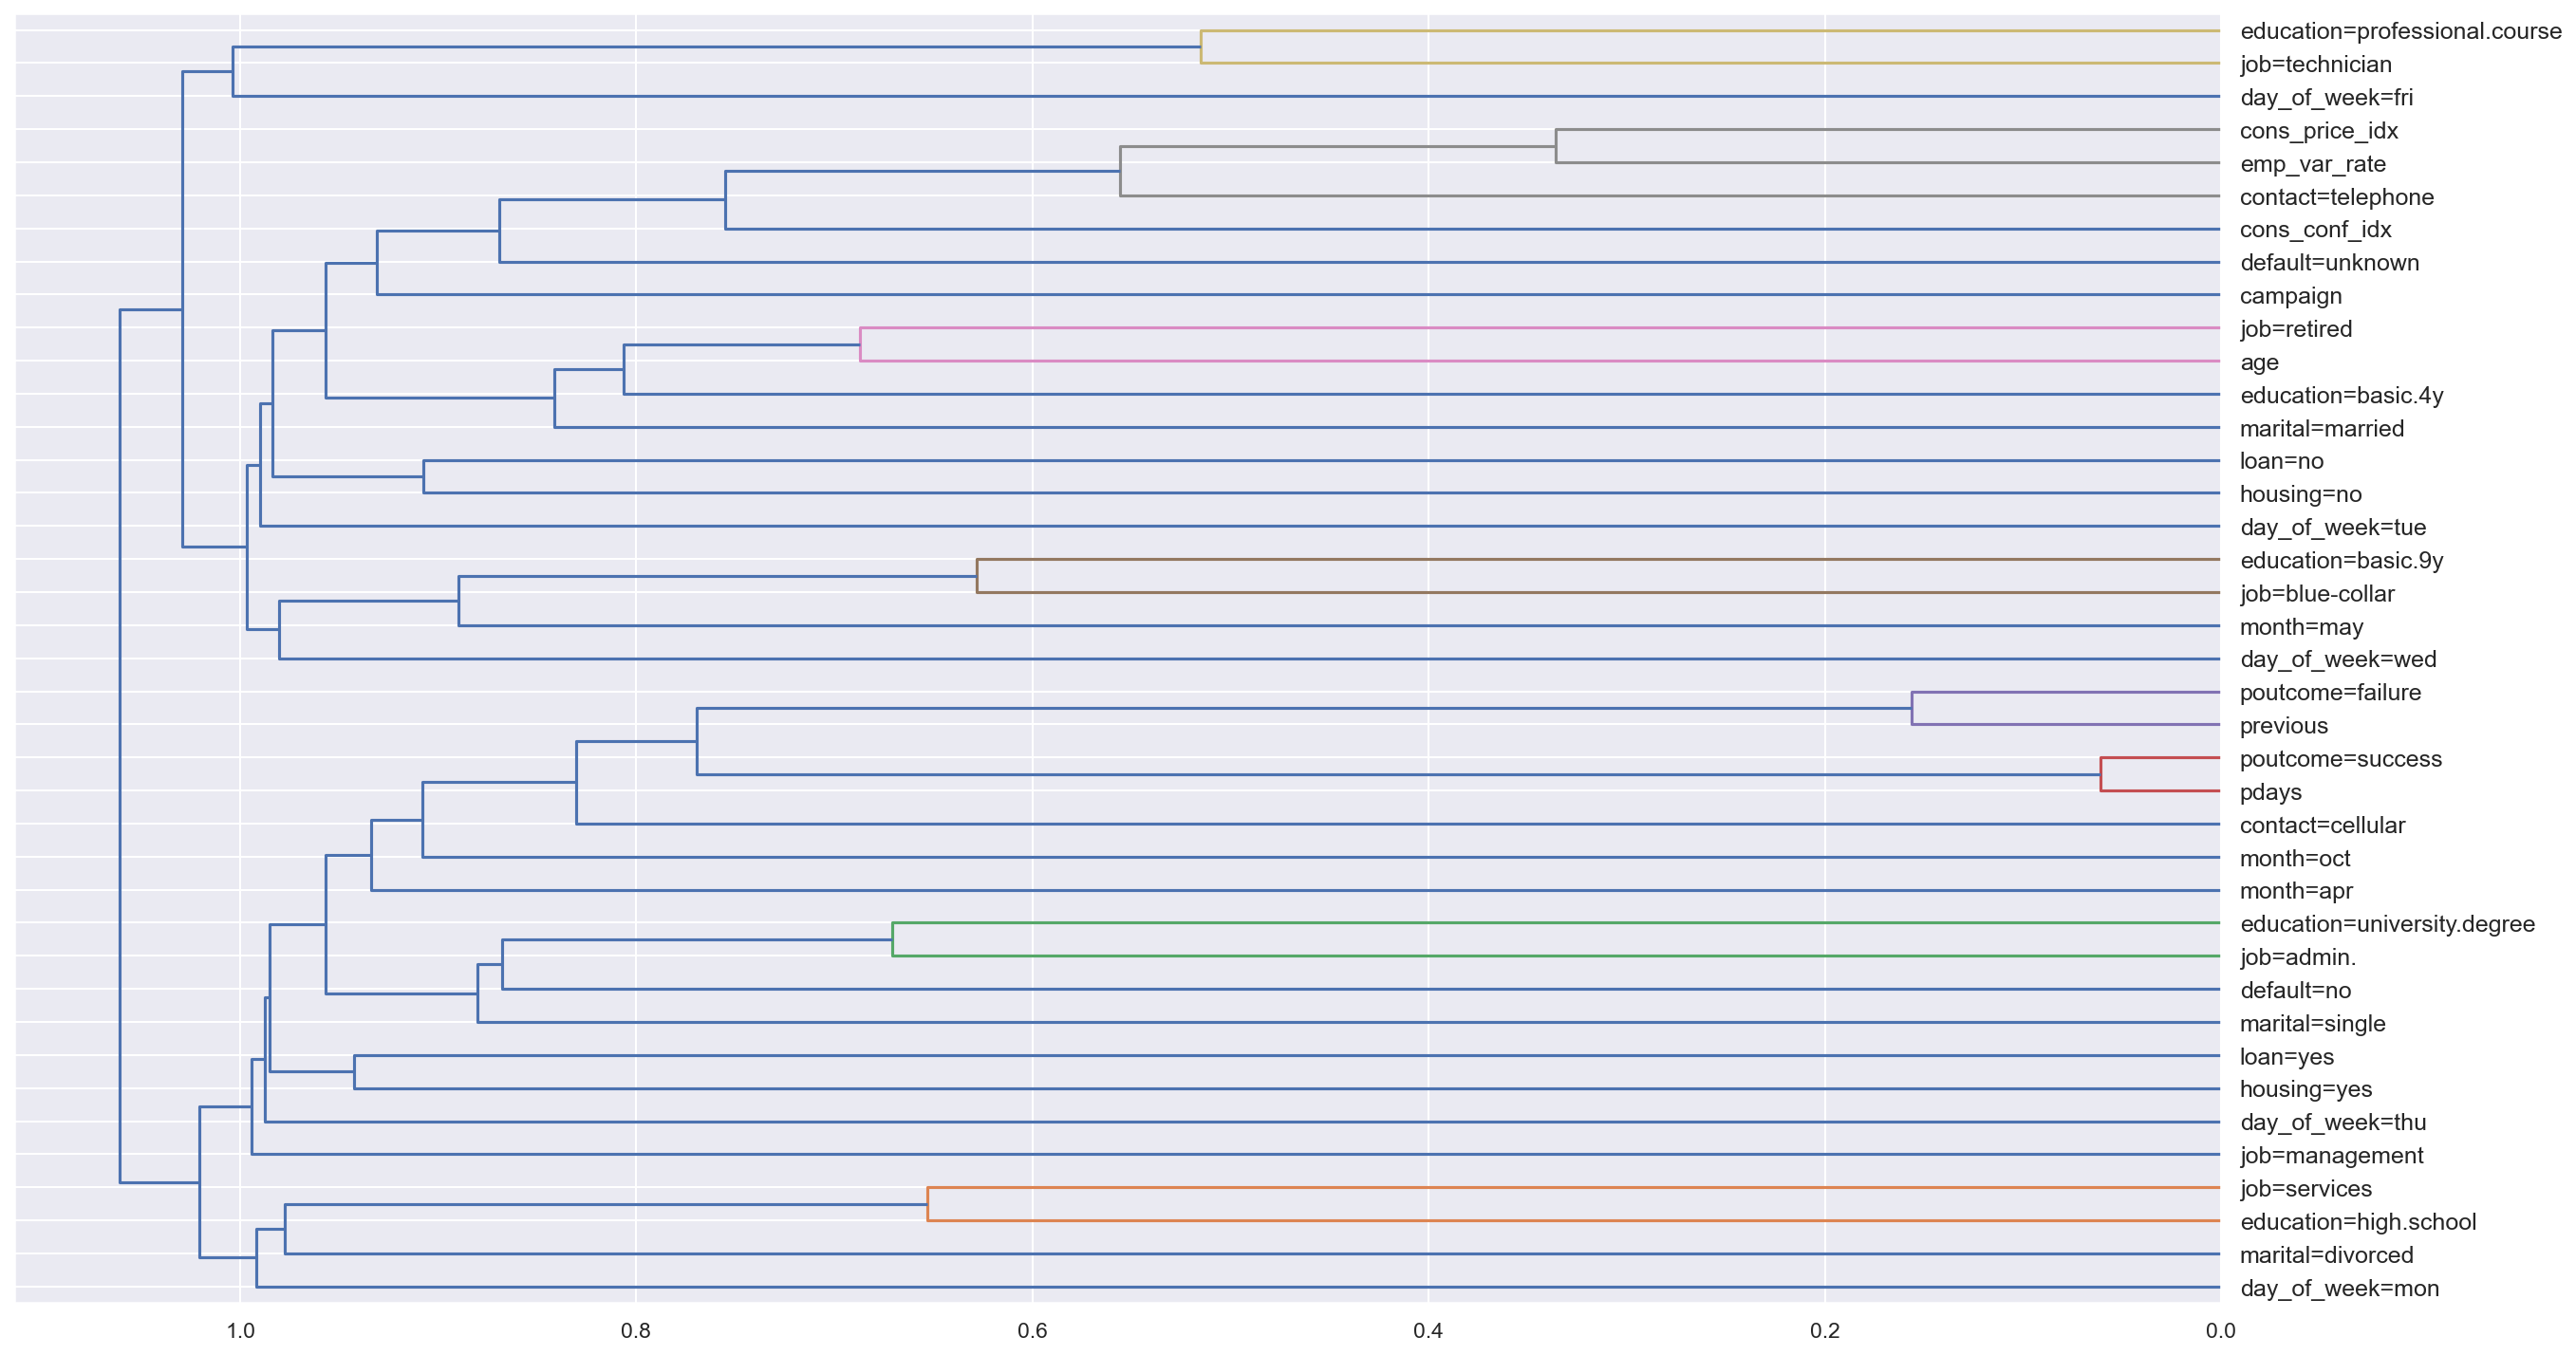

In [88]:
import scipy
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(20,12), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

cluster_columns(X[to_keep])

### Tuning Hyperparameters

In [89]:
from sklearn.model_selection import RandomizedSearchCV , GridSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(start = 1, stop = 45, num = 15)]

# Minimum number of samples required to split a node
min_samples_split = [2,3,5,7,9,10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 4, 7, 10, 13, 16, 19, 23, 26, 29, 32, 35, 38, 41, 45], 'min_samples_split': [2, 3, 5, 7, 9, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [90]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=5,scoring = "roc_auc" ,random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X,y)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 4, 7, 10, 13, 16, 19,
                                                      23, 26, 29, 32, 35, 38,
                                                      41, 45],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 3, 5, 7, 9,
                                                              10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='roc_auc', verbose=5)

In [91]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [92]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [9,10,11],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2],
    'min_samples_split': [1,2,3],
    'n_estimators': [1500,1600,1700]
}

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2,scoring='roc_auc')
grid_search.fit(X[to_keep],y)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [9, 10, 11],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [1500, 1600, 1700]},
             scoring='roc_auc', verbose=2)

In [93]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1700}

In [94]:
params = {
    'bootstrap': True,
     'max_depth': 9,
     'max_features': 'sqrt',
     'min_samples_leaf': 1,
     'min_samples_split': 2,
     'n_estimators': 1700
}

In [95]:
folds = StratifiedKFold(n_splits = 5, random_state = 228, shuffle = True)
auc_score = 0
overall_auc = 0

for fold, (trn_idx, val_idx) in enumerate(folds.split(X,y)):
    
    X_train, X_val = X.iloc[trn_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[trn_idx], y.iloc[val_idx]

    classifier = RandomForestClassifier(**params)
   
    classifier.fit(X_train, y_train)
    preds = classifier.predict_proba(X_val)[:,1]
   
    auc_score = roc_auc_score(y_val, preds)
    print(f"The AUC of {fold + 1} fold is {auc_score}")
    overall_auc += auc_score 

print(f"The over all AUC is {overall_auc / 5}")

The AUC of 1 fold is 0.7893300310470831
The AUC of 2 fold is 0.7851525482944385
The AUC of 3 fold is 0.8015344246518264
The AUC of 4 fold is 0.8084674221817402
The AUC of 5 fold is 0.7832898397701276
The over all AUC is 0.7935548531890431


In [43]:
predicitions = classifier.predict_proba(X_test)[:,1]
roc_auc_score(y_test,predicitions)

0.8067907831737346

In [ ]:
rfc_disp = plot_roc_curve(classifier, X_test, y_test)
rfc_disp.figure_.suptitle("ROC curve")

plt.show()

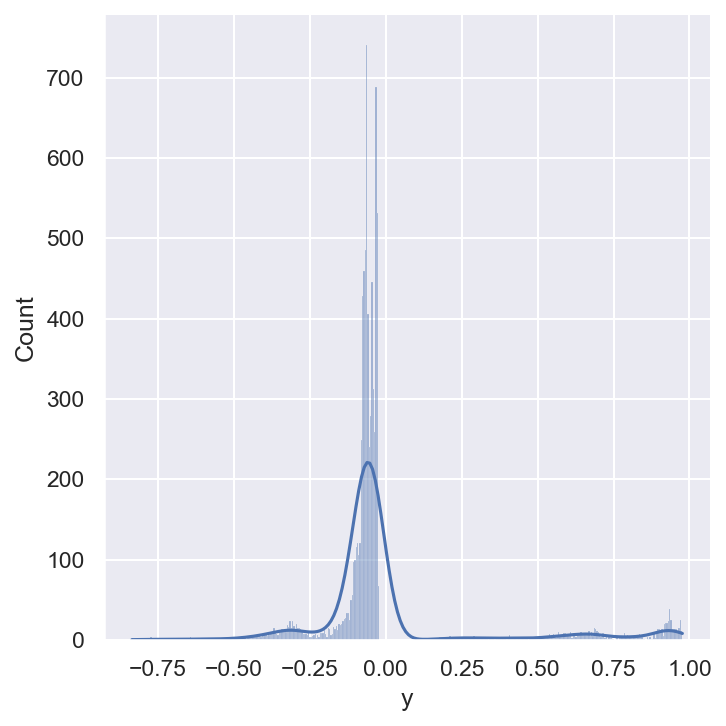

In [44]:
sns.displot(y_test-predicitions , kde = True)

In [45]:
dump((dv,classifier),"train_model.joblib")

['train_model.joblib']